# TAA Project 1 - Drug Classification

### Importing libraries

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_graphviz
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler, RobustScaler
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report, roc_curve, auc
from sklearn.model_selection import KFold, GridSearchCV
from imblearn.over_sampling import SMOTE
from lime import lime_tabular
import shap

To avoid getting tons of FutureWarnings:

In [34]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

### Loading dataset

In [35]:
df = pd.read_csv("drug200.csv", delimiter=",")
df

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,F,HIGH,HIGH,25.355,DrugY
1,47,M,LOW,HIGH,13.093,drugC
2,47,M,LOW,HIGH,10.114,drugC
3,28,F,NORMAL,HIGH,7.798,drugX
4,61,F,LOW,HIGH,18.043,DrugY
...,...,...,...,...,...,...
195,56,F,LOW,HIGH,11.567,drugC
196,16,M,LOW,HIGH,12.006,drugC
197,52,M,NORMAL,HIGH,9.894,drugX
198,23,M,NORMAL,NORMAL,14.020,drugX


### Data Preprocessing

In [6]:
df.isnull().sum() # search for missing values

Age            0
Sex            0
BP             0
Cholesterol    0
Na_to_K        0
Drug           0
dtype: int64

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          200 non-null    int64  
 1   Sex          200 non-null    object 
 2   BP           200 non-null    object 
 3   Cholesterol  200 non-null    object 
 4   Na_to_K      200 non-null    float64
 5   Drug         200 non-null    object 
dtypes: float64(1), int64(1), object(4)
memory usage: 9.5+ KB


In [8]:
df.describe()

,Age,Na_to_K
count,200.000000,200.000000
mean,44.315000,16.084485
std,16.544315,7.223956
min,15.000000,6.269000
25%,31.000000,10.445500
50%,45.000000,13.936500
75%,58.000000,19.380000
max,74.000000,38.247000


In [36]:
list_str = df.select_dtypes(include = 'object').columns # list of columns with string values
le = LabelEncoder()

for col in list_str:
    df[col] = le.fit_transform(df[col])

mapping = dict(zip(le.transform(le.classes_), le.classes_))
mapping

{0: 'DrugY', 1: 'drugA', 2: 'drugB', 3: 'drugC', 4: 'drugX'}

In [10]:
df.corr()
# Negative correlation between Age and Na_to_K means that the older the patient is, the lower the Na_to_K value is (and vice versa)

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
Age,1.000000,0.102027,0.054212,-0.068234,-0.063119,0.041856
Sex,0.102027,1.000000,-0.007814,-0.008811,-0.125008,0.018239
BP,0.054212,-0.007814,1.000000,-0.137552,-0.149312,0.419397
Cholesterol,-0.068234,-0.008811,-0.137552,1.000000,0.010000,0.048415
Na_to_K,-0.063119,-0.125008,-0.149312,0.010000,1.000000,-0.689051
Drug,0.041856,0.018239,0.419397,0.048415,-0.689051,1.000000


### Exploratory Data Analysis (EDA)

<AxesSubplot:xlabel='Drug', ylabel='count'>

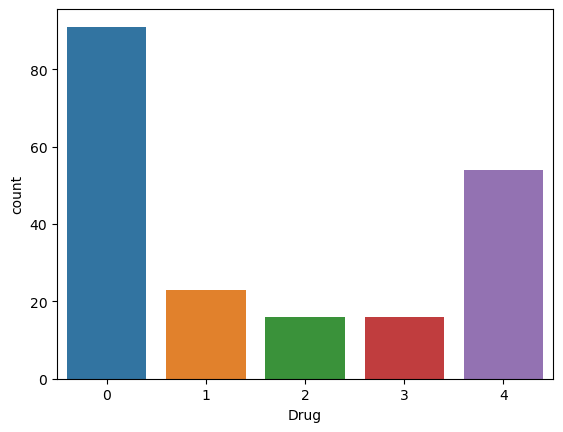

In [11]:
sns.countplot(x="Drug", data=df)

<AxesSubplot:xlabel='Drug', ylabel='count'>

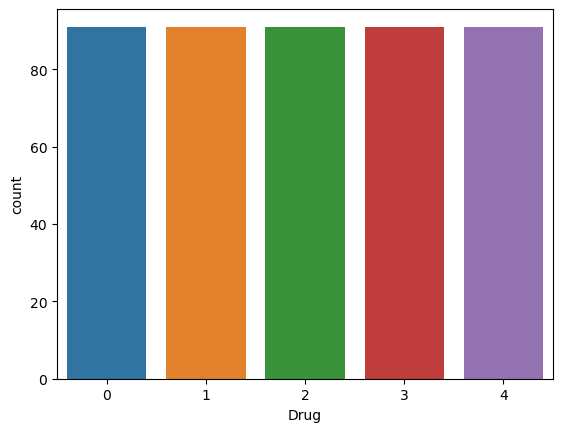

In [37]:
X = df.drop('Drug', axis=1)
y = df['Drug']

sm = SMOTE(random_state=0)
_, y_oversampled = sm.fit_resample(X, y)

plot_df = pd.DataFrame(y_oversampled, columns=['Drug'])
sns.countplot(x="Drug", data=plot_df)

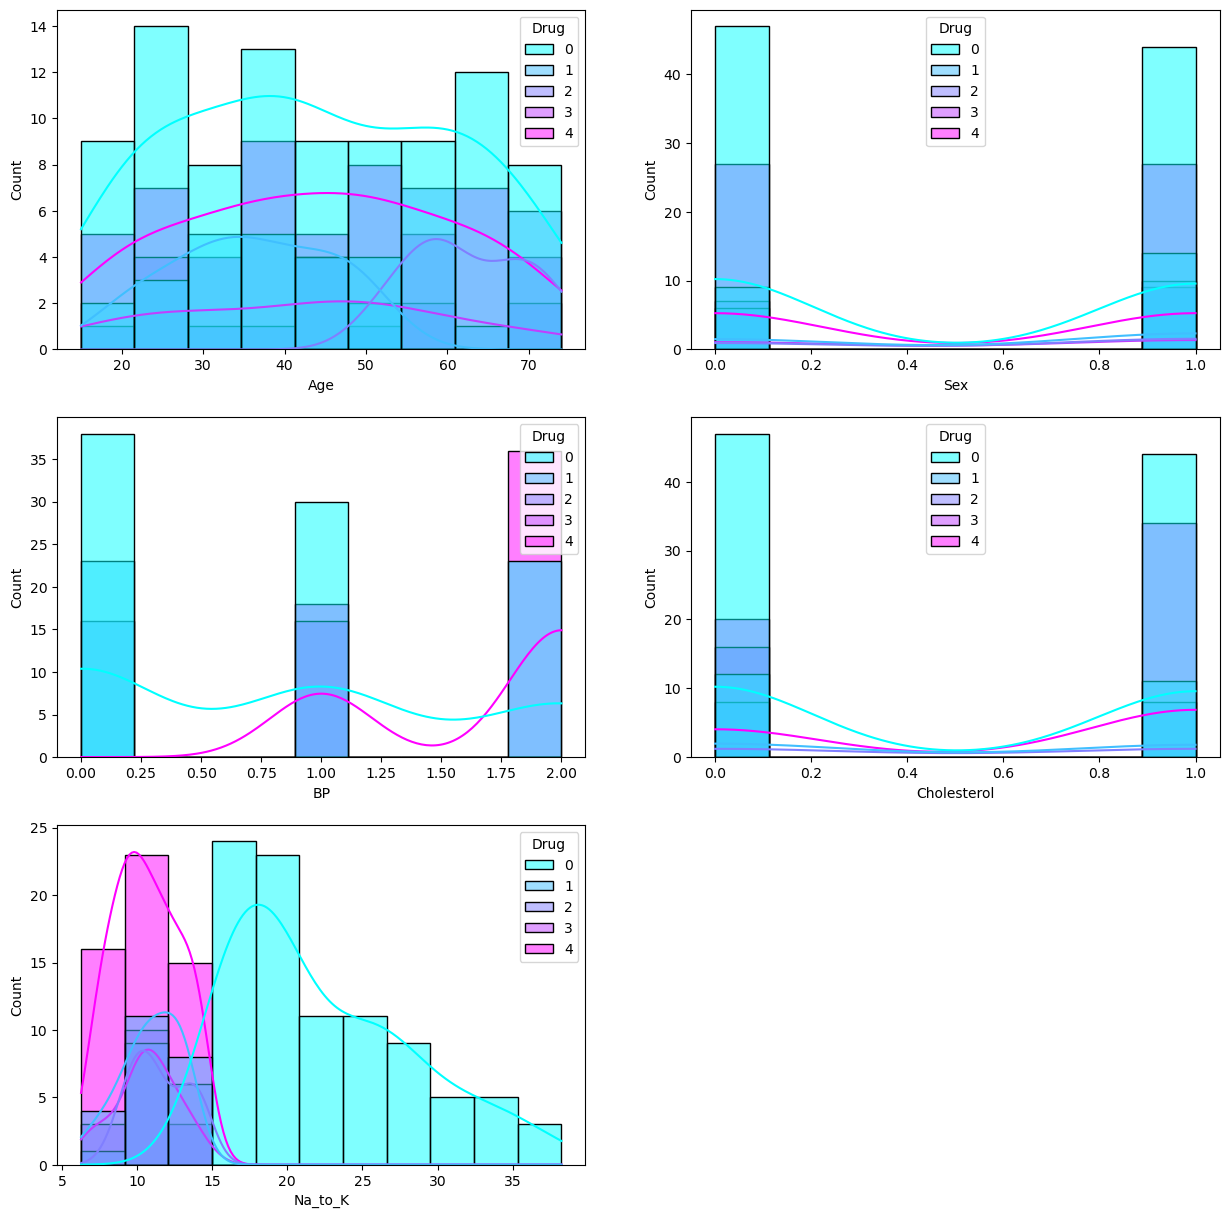

In [13]:
fig, axs = plt.subplots(3, 2, figsize=(15,15))

i = 1
for feature in df.columns:
    plt.subplot(3, 2, i)
    sns.histplot(data = df, x = feature, kde = True, palette = "cool", hue = "Drug")
    i+=1

plt.delaxes(axs[2,1]) # delete empty subplot

# save plot
plt.savefig('histograms.png')

<AxesSubplot:xlabel='Na_to_K', ylabel='Count'>

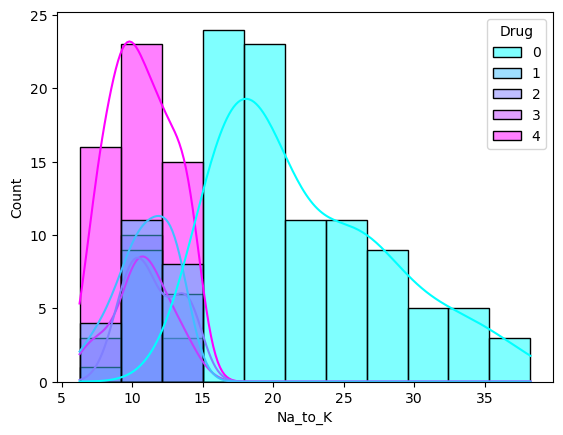

In [14]:
sns.histplot(data = df, x = "Na_to_K", kde = True, palette = "cool", hue = "Drug")

<AxesSubplot:xlabel='Na_to_K'>

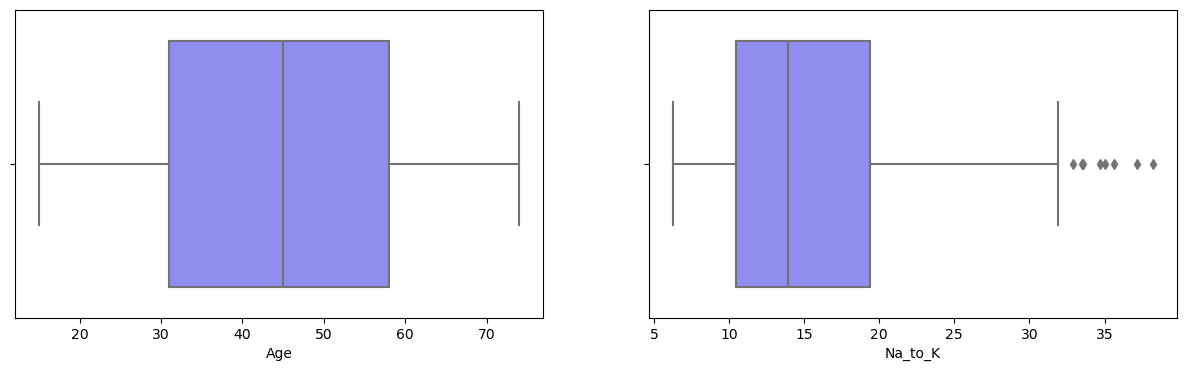

In [15]:
fig, axs = plt.subplots(1, 2, figsize=(15, 4))

plt.subplot(1, 2, 1)
sns.boxplot(data = df, x = "Age", palette = "cool")

plt.subplot(1, 2, 2)
sns.boxplot(data = df, x = "Na_to_K", palette = "cool")

<AxesSubplot:xlabel='Na_to_K'>

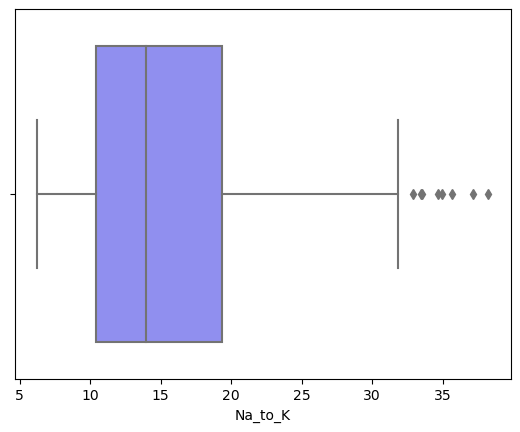

In [16]:
sns.boxplot(data = df, x = "Na_to_K", palette = "cool")

#### Outliers Removal

In [17]:
for i in range(2):
    q1 = df["Na_to_K"].quantile(0.25)
    q3 = df["Na_to_K"].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    filter_ = (df["Na_to_K"] > lower_bound) & (df["Na_to_K"] < upper_bound)
    # df = df[filter_]

print("Maximum value", upper_bound)
df[(filter_ == False)]

Maximum value 32.78175


,Age,Sex,BP,Cholesterol,Na_to_K,Drug
24,33,0,1,0,33.486,0
96,58,0,1,0,38.247,0
98,20,1,0,1,35.639,0
128,47,1,1,1,33.542,0
131,52,1,1,1,32.922,0
184,18,0,0,0,37.188,0
188,65,1,0,1,34.997,0
194,46,0,0,0,34.686,0


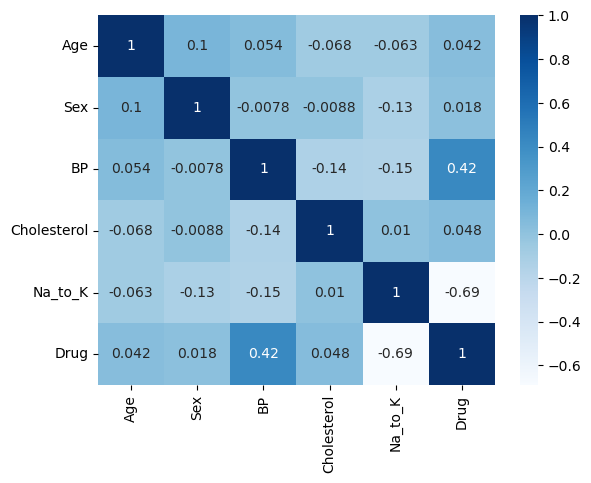

In [18]:
sns.heatmap(df.corr(), annot=True, cmap='Blues')#, fmt='.1f')

# save plot
plt.savefig('heatmap.png')

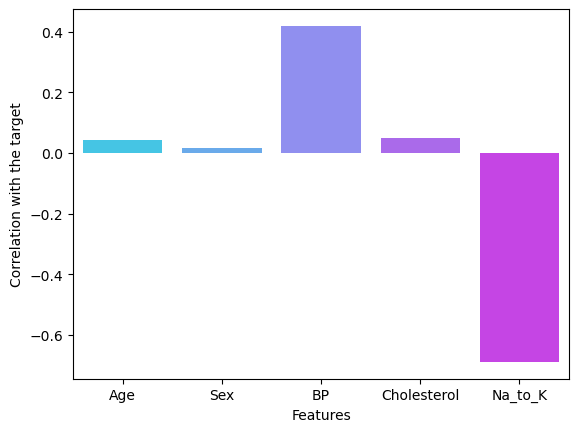

In [19]:
# plot graphbar with the correlation between the features and the target
df_corr = df.corr().drop('Drug', axis=1).loc[['Drug']]

sns.barplot(x = df_corr.columns, y = df_corr.values[0], palette = "cool")

plt.xlabel('Features')
plt.ylabel('Correlation with the target')
plt.savefig('graphbar.png')
plt.show()

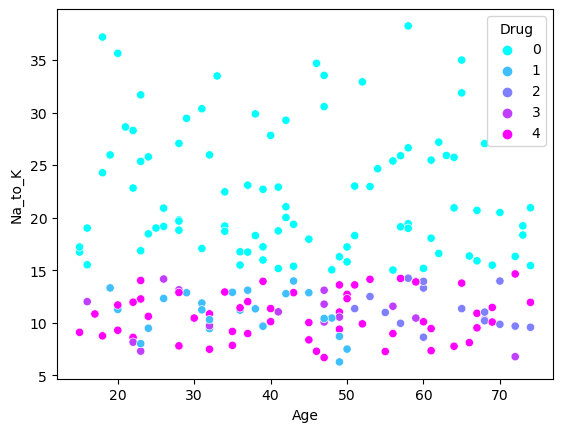

In [20]:
sns.scatterplot(data = df, x = 'Age', y = 'Na_to_K', palette = 'cool', hue = 'Drug')
plt.savefig('scatterplot.png')
plt.xlabel('Age')
plt.ylabel('Na_to_K')
plt.show()

### Feature Scaling

In [38]:
X = RobustScaler().fit_transform(X)

pd.DataFrame(X, columns=df.columns[:-1]).describe()

,Age,Sex,BP,Cholesterol,Na_to_K
count,200.000000,200.000000,200.000000,200.000000,200.000000
mean,-0.025370,-0.480000,-0.045000,0.485000,0.240415
std,0.612752,0.500854,0.410876,0.501029,0.808546
min,-1.111111,-1.000000,-0.500000,0.000000,-0.858190
25%,-0.518519,-1.000000,-0.500000,0.000000,-0.390733
50%,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.481481,0.000000,0.500000,1.000000,0.609267
max,1.074074,0.000000,0.500000,1.000000,2.720969


## Logistic Regression

In [40]:
def plot_confusion_matrix(y_test, y_pred):
    cm = sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cmap='Blues')
    cm.set_title('Confusion Matrix')
    cm.set_xlabel('Predicted Values')
    cm.set_ylabel('Actual Values')
    plt.show()

In [23]:
def sigmoid(z):
    """
    return the sigmoid of z
    """
    return 1/(1+np.exp(-z))

def costFunction(theta, X, y):
    """
    Takes in numpy array theta, x and y and return the logistic regression cost function and gradient
    """
    
    m = y.shape[0] # number of training examples 
    
    #vector of the model predictions for all training examples   
    h = sigmoid(np.dot(X,theta))
    error = (-y * np.log(h)) - ((1-y)*np.log(1-h))
    cost = 1/m * sum(error) # cost function
    grad = 1/m * np.dot(X.transpose(),(h - y)) # vector of gradients of all model parameters theta
    return cost[0] , grad

def gradientDescent(X,y,theta,alpha,num_iters):
    """
    Take in numpy array X, y and theta and update theta by taking num_iters gradient steps
    with learning rate of alpha
    
    return theta and the list of the cost of theta during each iteration
    """
    #number of training examples
    m = y.shape[0]
    J_history =[]
    
    for i in range(num_iters):
        cost, grad = costFunction(theta, X, y)
        theta -= alpha * grad
        J_history.append(cost)
    
    return theta , J_history

def predict(theta0, theta1, theta2, theta3, theta4, X):
    """
    takes in numpy array of theta and X and predict the class 
    """
    
    X_theta0 = X.dot(theta0)
    X_theta1 = X.dot(theta1)
    X_theta2 = X.dot(theta2)
    X_theta3 = X.dot(theta3)
    X_theta4 = X.dot(theta4)

    X_theta = np.column_stack((X_theta0, X_theta1, X_theta2, X_theta3, X_theta4))

    return np.argmax(X_theta, axis=1)

              precision    recall  f1-score   support

           0    0.95238   1.00000   0.97561        20
           1    0.85714   1.00000   0.92308         6
           2    1.00000   1.00000   1.00000         3
           3    0.00000   0.00000   0.00000         6
           4    0.78947   1.00000   0.88235        15

    accuracy                        0.88000        50
   macro avg    0.71980   0.80000   0.75621        50
weighted avg    0.78065   0.88000   0.82572        50



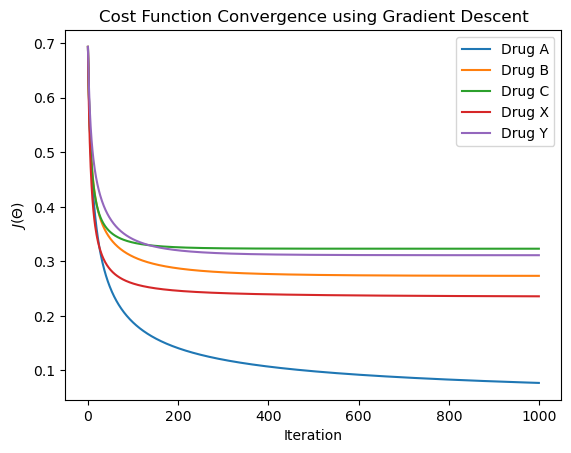

In [24]:
alpha = 0.5
num_iters = 1000

y0 = (y == 0).astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y0, test_size=0.2, random_state=42)

theta0 = np.zeros((X_train.shape[1], 1))
y_train = y_train.values.reshape(-1,1)

theta0, J_history0 = gradientDescent(X_train, y_train, theta0, alpha, num_iters)

y1 = (y == 1).astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y1, test_size=0.2, random_state=42)

theta1 = np.zeros((X_train.shape[1], 1))
y_train = y_train.values.reshape(-1,1)

theta1, J_history1 = gradientDescent(X_train, y_train, theta1, alpha, num_iters)

y2 = (y == 2).astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y2, test_size=0.2, random_state=42)

theta2 = np.zeros((X_train.shape[1], 1))
y_train = y_train.values.reshape(-1,1)

theta2, J_history2 = gradientDescent(X_train, y_train, theta2, alpha, num_iters)

y3 = (y == 3).astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y3, test_size=0.2, random_state=42)

theta3 = np.zeros((X_train.shape[1], 1))
y_train = y_train.values.reshape(-1,1)

theta3, J_history3 = gradientDescent(X_train, y_train, theta3, alpha, num_iters)

y4 = (y == 4).astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y4, test_size=0.2, random_state=42)

theta4 = np.zeros((X_train.shape[1], 1))
y_train = y_train.values.reshape(-1,1)

theta4, J_history4 = gradientDescent(X_train, y_train, theta4, alpha, num_iters)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)


y_pred = predict(theta0, theta1, theta2, theta3, theta4, X_test)

print(classification_report(y_test, y_pred, digits = 5, zero_division=0))

plt.plot(J_history0)
plt.plot(J_history1)
plt.plot(J_history2)
plt.plot(J_history3)
plt.plot(J_history4)

plt.xlabel("Iteration")
plt.ylabel("$J(\Theta)$")
plt.title("Cost Function Convergence using Gradient Descent")
plt.legend(['Drug A', 'Drug B', 'Drug C', 'Drug X', 'Drug Y'])
plt.show()

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

lr = LogisticRegression(penalty = "none") # by default, solver = "lbfgs"

lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

print(classification_report(y_test, y_pred, digits = 5, zero_division=0))

# plot_confusion_matrix(y_test, y_pred)

              precision    recall  f1-score   support

           0    1.00000   0.95000   0.97436        20
           1    1.00000   1.00000   1.00000         6
           2    0.75000   1.00000   0.85714         3
           3    1.00000   1.00000   1.00000         6
           4    1.00000   1.00000   1.00000        15

    accuracy                        0.98000        50
   macro avg    0.95000   0.99000   0.96630        50
weighted avg    0.98500   0.98000   0.98117        50



In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

lr = LogisticRegression(penalty = "l1", solver = 'liblinear')

lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

print(classification_report(y_test, y_pred, digits = 5, target_names = mapping.values(), zero_division=0))
# plot_confusion_matrix(y_test, y_pred)

              precision    recall  f1-score   support

       DrugY    0.95238   1.00000   0.97561        20
       drugA    1.00000   1.00000   1.00000         6
       drugB    1.00000   1.00000   1.00000         3
       drugC    0.00000   0.00000   0.00000         6
       drugX    0.75000   1.00000   0.85714        15

    accuracy                        0.88000        50
   macro avg    0.74048   0.80000   0.76655        50
weighted avg    0.78595   0.88000   0.82739        50



In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

lr = LogisticRegression(penalty = "l2")

lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

print(classification_report(y_test, y_pred, digits = 5, target_names = mapping.values(), zero_division=0))
# plot_confusion_matrix(y_test, y_pred)

              precision    recall  f1-score   support

       DrugY    0.95000   0.95000   0.95000        20
       drugA    0.85714   1.00000   0.92308         6
       drugB    0.75000   1.00000   0.85714         3
       drugC    0.00000   0.00000   0.00000         6
       drugX    0.78947   1.00000   0.88235        15

    accuracy                        0.86000        50
   macro avg    0.66932   0.79000   0.72251        50
weighted avg    0.76470   0.86000   0.80690        50



In [28]:
explainer = lime_tabular.LimeTabularExplainer(
    training_data=X_train,
    feature_names=df.columns[:-1],
    class_names=list(mapping.values()),
    mode='classification'
)

exp = explainer.explain_instance(
    data_row=X_test[3],
    predict_fn=lr.predict_proba,
    top_labels=5,
)

exp.show_in_notebook(show_table=True)

exp.save_to_file('lime_oi.html')

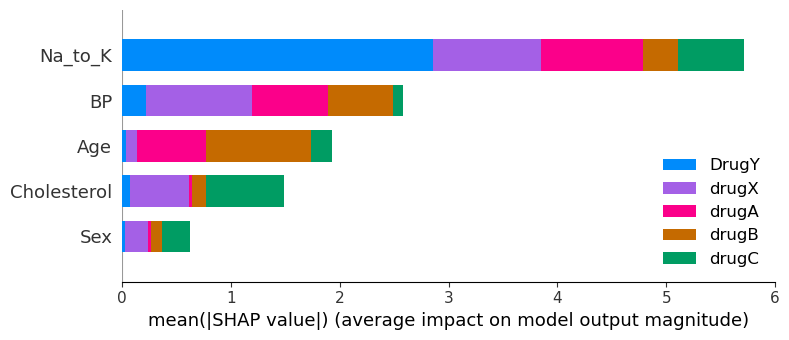

In [32]:
explainer = shap.LinearExplainer(lr, X_train)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test, feature_names=df.columns[:-1], class_names=list(mapping.values()))

In [175]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

lr = LogisticRegression(penalty = "none")
y_pred = cross_val_predict(lr, X, y, cv=7)

print(classification_report(y, y_pred, digits = 5, target_names = mapping.values(), zero_division=0))

              precision    recall  f1-score   support

       DrugY    0.97753   0.95604   0.96667        91
       drugA    0.95833   1.00000   0.97872        23
       drugB    0.88889   1.00000   0.94118        16
       drugC    1.00000   1.00000   1.00000        16
       drugX    0.98113   0.96296   0.97196        54

    accuracy                        0.97000       200
   macro avg    0.96118   0.98380   0.97171       200
weighted avg    0.97100   0.97000   0.97011       200



In [176]:
def plot_multi_class_roc_curve(y_test, y_pred):
    y_test = pd.get_dummies(y_test)
    y_pred = pd.get_dummies(y_pred)

    for i in range(len(y_test.columns)):
        fpr, tpr, _ = roc_curve(y_test.iloc[:, i], y_pred.iloc[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label='ROC curve (area = %0.2f) for label %s' % (roc_auc, y_test.columns[i]))
    plt.legend(loc="lower right")
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.show()

{'C': 100}


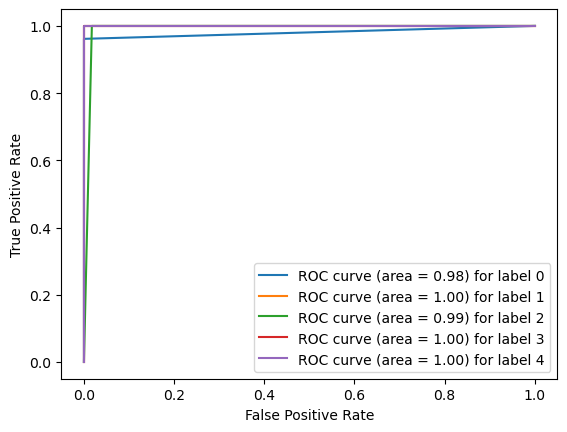

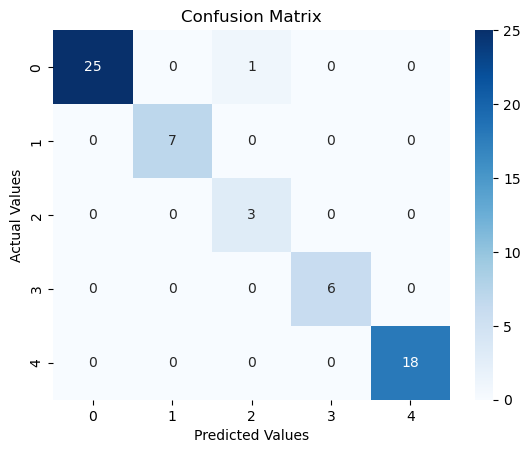

              precision    recall  f1-score   support

       DrugY    1.00000   0.96154   0.98039        26
       drugA    1.00000   1.00000   1.00000         7
       drugB    0.75000   1.00000   0.85714         3
       drugC    1.00000   1.00000   1.00000         6
       drugX    1.00000   1.00000   1.00000        18

    accuracy                        0.98333        60
   macro avg    0.95000   0.99231   0.96751        60
weighted avg    0.98750   0.98333   0.98436        60



In [221]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

parameters = {'C':[1, 10, 100, 1000]}

lr_tunned = GridSearchCV(
                estimator = LogisticRegression(penalty='l2'),
                param_grid = parameters,
                scoring = 'accuracy',
                cv = 5,
                verbose=0
            )

lr_tunned.fit(X_train, y_train)
y_pred = lr_tunned.predict(X_test)

print(lr_tunned.best_params_)
# C is the inverse of regularization strength, higher C means less regularization

plot_multi_class_roc_curve(y_test, y_pred)
plot_confusion_matrix(y_test, y_pred)

print(classification_report(y_test, y_pred, digits = 5, target_names = mapping.values(), zero_division=0))

In [178]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

lr = SGDClassifier(loss = "log", penalty = "none")
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

print(classification_report(y_test, y_pred, digits = 5, target_names = mapping.values(), zero_division=0))

              precision    recall  f1-score   support

       DrugY    0.90476   0.95000   0.92683        20
       drugA    0.85714   1.00000   0.92308         6
       drugB    0.75000   1.00000   0.85714         3
       drugC    1.00000   0.66667   0.80000         6
       drugX    1.00000   0.93333   0.96552        15

    accuracy                        0.92000        50
   macro avg    0.90238   0.91000   0.89451        50
weighted avg    0.92976   0.92000   0.91858        50



In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

lr = SGDClassifier(loss = "log", penalty = "none")
y_pred = cross_val_predict(lr, X, y, cv=7)

print(classification_report(y, y_pred, digits = 5, target_names = mapping.values(), zero_division=0))

              precision    recall  f1-score   support

       DrugY    0.98876   0.96703   0.97778        91
       drugA    0.95455   0.91304   0.93333        23
       drugB    0.85714   0.75000   0.80000        16
       drugC    0.77778   0.87500   0.82353        16
       drugX    0.92982   0.98148   0.95495        54

    accuracy                        0.94000       200
   macro avg    0.90161   0.89731   0.89792       200
weighted avg    0.94151   0.94000   0.93994       200



{'alpha': 0.001}


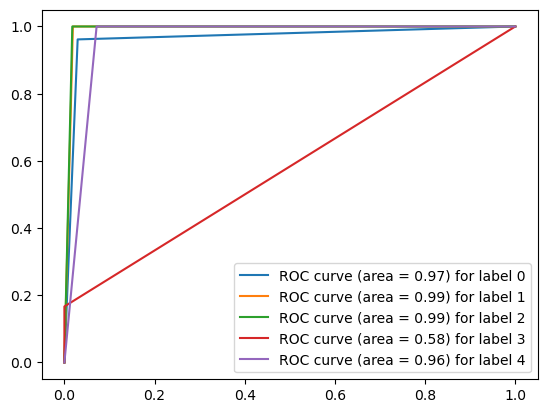

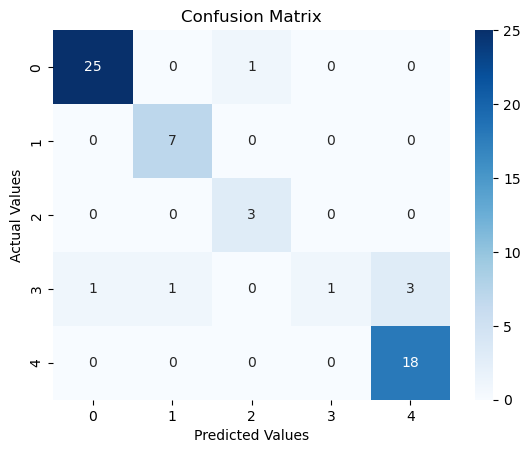

              precision    recall  f1-score   support

       DrugY    0.96154   0.96154   0.96154        26
       drugA    0.87500   1.00000   0.93333         7
       drugB    0.75000   1.00000   0.85714         3
       drugC    1.00000   0.16667   0.28571         6
       drugX    0.85714   1.00000   0.92308        18

    accuracy                        0.90000        60
   macro avg    0.88874   0.82564   0.79216        60
weighted avg    0.91339   0.90000   0.87391        60



In [85]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

parameters = {'alpha':[0.0001, 0.001, 0.01, 0.1, 1, 10]}

lr_tunned = GridSearchCV(
                estimator = SGDClassifier(loss = "log", penalty = "none"),
                param_grid = parameters,
                scoring = 'accuracy',
                cv = 5,
                verbose=0
            )

lr_tunned.fit(X_train, y_train)
y_pred = lr_tunned.predict(X_test)

print(lr_tunned.best_params_)
plot_multi_class_roc_curve(y_test, y_pred)
plot_confusion_matrix(y_test, y_pred)
print(classification_report(y_test, y_pred, digits = 5, target_names = mapping.values(), zero_division=0))


## Gaussian Naive Bayes

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

nb = GaussianNB()

nb.fit(X_train, y_train)
y_pred = nb.predict(X_test)

print(classification_report(y_test, y_pred, digits = 5, target_names = mapping.values(), zero_division=0))

              precision    recall  f1-score   support

       DrugY    1.00000   0.70000   0.82353        20
       drugA    0.75000   1.00000   0.85714         6
       drugB    0.60000   1.00000   0.75000         3
       drugC    0.75000   1.00000   0.85714         6
       drugX    1.00000   1.00000   1.00000        15

    accuracy                        0.88000        50
   macro avg    0.82000   0.94000   0.85756        50
weighted avg    0.91600   0.88000   0.88013        50



In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

nb = GaussianNB()
y_pred = cross_val_predict(nb, X, y, cv=5)

print(classification_report(y, y_pred, digits = 5, target_names = mapping.values(), zero_division=0))

              precision    recall  f1-score   support

       DrugY    0.98387   0.67033   0.79739        91
       drugA    0.63889   1.00000   0.77966        23
       drugB    0.73684   0.87500   0.80000        16
       drugC    0.57143   1.00000   0.72727        16
       drugX    0.96364   0.98148   0.97248        54

    accuracy                        0.83500       200
   macro avg    0.77893   0.90536   0.81536       200
weighted avg    0.88598   0.83500   0.83722       200



{'var_smoothing': 0.01519911082952933}


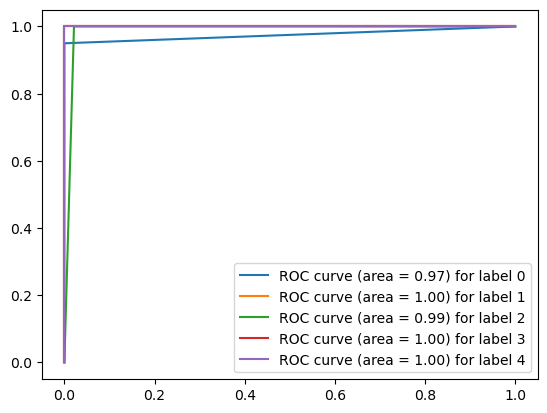

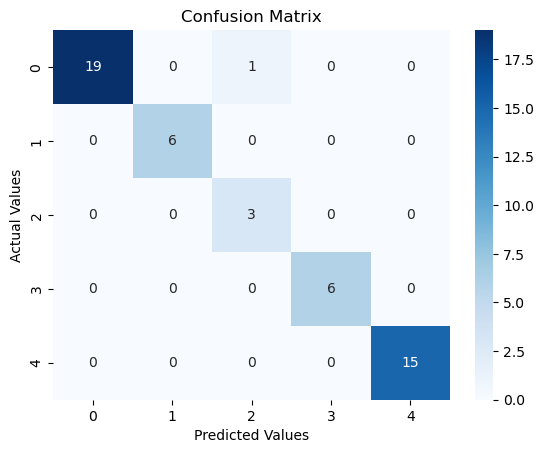

              precision    recall  f1-score   support

       DrugY    1.00000   0.95000   0.97436        20
       drugA    1.00000   1.00000   1.00000         6
       drugB    0.75000   1.00000   0.85714         3
       drugC    1.00000   1.00000   1.00000         6
       drugX    1.00000   1.00000   1.00000        15

    accuracy                        0.98000        50
   macro avg    0.95000   0.99000   0.96630        50
weighted avg    0.98500   0.98000   0.98117        50



In [86]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

nb = GaussianNB()

params_NB = {'var_smoothing': np.logspace(0,-9, num=100)}
nb_tunned = GridSearchCV(estimator = nb,
            param_grid = params_NB, 
            cv = 5,
            scoring='accuracy'
        ) 

nb_tunned.fit(X_train, y_train)
y_pred = nb_tunned.predict(X_test)

print(nb_tunned.best_params_)
# var_smoothing means
plot_multi_class_roc_curve(y_test, y_pred)
plot_confusion_matrix(y_test, y_pred)

print(classification_report(y_test, y_pred, digits = 5, target_names = mapping.values(), zero_division=0))

## Decision Tree

              precision    recall  f1-score   support

       DrugY    1.00000   1.00000   1.00000        20
       drugA    1.00000   1.00000   1.00000         6
       drugB    1.00000   1.00000   1.00000         3
       drugC    1.00000   1.00000   1.00000         6
       drugX    1.00000   1.00000   1.00000        15

    accuracy                        1.00000        50
   macro avg    1.00000   1.00000   1.00000        50
weighted avg    1.00000   1.00000   1.00000        50



[Text(0.625, 0.9, 'Na_to_K <= 0.1\nentropy = 1.938\nsamples = 150\nvalue = [71, 17, 13, 10, 39]\nclass = DrugY'),
 Text(0.5, 0.7, 'BP <= -0.25\nentropy = 1.786\nsamples = 79\nvalue = [0, 17, 13, 10, 39]\nclass = drugX'),
 Text(0.25, 0.5, 'Age <= 0.204\nentropy = 0.987\nsamples = 30\nvalue = [0, 17, 13, 0, 0]\nclass = drugA'),
 Text(0.125, 0.3, 'entropy = 0.0\nsamples = 17\nvalue = [0, 17, 0, 0, 0]\nclass = drugA'),
 Text(0.375, 0.3, 'entropy = 0.0\nsamples = 13\nvalue = [0, 0, 13, 0, 0]\nclass = drugB'),
 Text(0.75, 0.5, 'BP <= 0.25\nentropy = 0.73\nsamples = 49\nvalue = [0, 0, 0, 10, 39]\nclass = drugX'),
 Text(0.625, 0.3, 'Cholesterol <= 0.5\nentropy = 0.998\nsamples = 21\nvalue = [0, 0, 0, 10, 11]\nclass = drugX'),
 Text(0.5, 0.1, 'entropy = 0.0\nsamples = 10\nvalue = [0, 0, 0, 10, 0]\nclass = drugC'),
 Text(0.75, 0.1, 'entropy = 0.0\nsamples = 11\nvalue = [0, 0, 0, 0, 11]\nclass = drugX'),
 Text(0.875, 0.3, 'entropy = 0.0\nsamples = 28\nvalue = [0, 0, 0, 0, 28]\nclass = drugX'),
 T

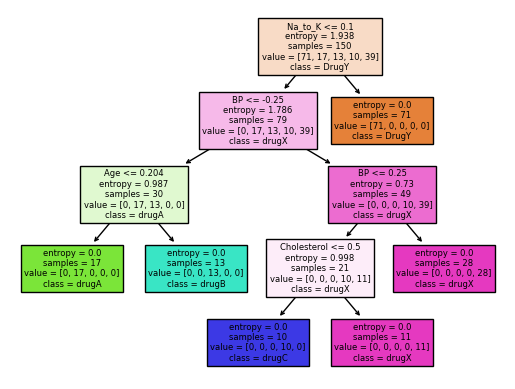

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

tree = DecisionTreeClassifier(criterion = 'entropy', max_depth = 5, random_state = 42)

tree.fit(X_train, y_train)
y_pred = tree.predict(X_test)

print(classification_report(y_test, y_pred, digits = 5, target_names = mapping.values(), zero_division=0))
plot_tree(tree, feature_names=df.columns[:-1], class_names=list(mapping.values()), filled=True)

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

tree = DecisionTreeClassifier(criterion = 'entropy', max_depth = 5, random_state = 42)
y_pred = cross_val_predict(tree, X, y, cv=7)

print(classification_report(y, y_pred, digits = 5, target_names = mapping.values(), zero_division=0))

              precision    recall  f1-score   support

       DrugY    0.98913   1.00000   0.99454        91
       drugA    0.95833   1.00000   0.97872        23
       drugB    1.00000   0.93750   0.96774        16
       drugC    1.00000   1.00000   1.00000        16
       drugX    1.00000   0.98148   0.99065        54

    accuracy                        0.99000       200
   macro avg    0.98949   0.98380   0.98633       200
weighted avg    0.99026   0.99000   0.98996       200



{'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2}


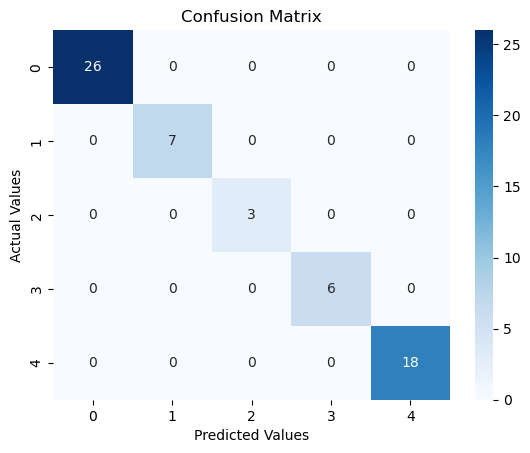

              precision    recall  f1-score   support

       DrugY    1.00000   1.00000   1.00000        26
       drugA    1.00000   1.00000   1.00000         7
       drugB    1.00000   1.00000   1.00000         3
       drugC    1.00000   1.00000   1.00000         6
       drugX    1.00000   1.00000   1.00000        18

    accuracy                        1.00000        60
   macro avg    1.00000   1.00000   1.00000        60
weighted avg    1.00000   1.00000   1.00000        60



[Text(0.625, 0.9, 'Na_to_K <= 0.1\ngini = 0.692\nsamples = 140\nvalue = [65, 16, 13, 10, 36]\nclass = DrugY'),
 Text(0.5, 0.7, 'BP <= -0.25\ngini = 0.676\nsamples = 75\nvalue = [0, 16, 13, 10, 36]\nclass = drugX'),
 Text(0.25, 0.5, 'Age <= 0.204\ngini = 0.495\nsamples = 29\nvalue = [0, 16, 13, 0, 0]\nclass = drugA'),
 Text(0.125, 0.3, 'gini = 0.0\nsamples = 16\nvalue = [0, 16, 0, 0, 0]\nclass = drugA'),
 Text(0.375, 0.3, 'gini = 0.0\nsamples = 13\nvalue = [0, 0, 13, 0, 0]\nclass = drugB'),
 Text(0.75, 0.5, 'BP <= 0.25\ngini = 0.34\nsamples = 46\nvalue = [0, 0, 0, 10, 36]\nclass = drugX'),
 Text(0.625, 0.3, 'Cholesterol <= 0.5\ngini = 0.499\nsamples = 21\nvalue = [0, 0, 0, 10, 11]\nclass = drugX'),
 Text(0.5, 0.1, 'gini = 0.0\nsamples = 10\nvalue = [0, 0, 0, 10, 0]\nclass = drugC'),
 Text(0.75, 0.1, 'gini = 0.0\nsamples = 11\nvalue = [0, 0, 0, 0, 11]\nclass = drugX'),
 Text(0.875, 0.3, 'gini = 0.0\nsamples = 25\nvalue = [0, 0, 0, 0, 25]\nclass = drugX'),
 Text(0.75, 0.7, 'gini = 0.0\nsa

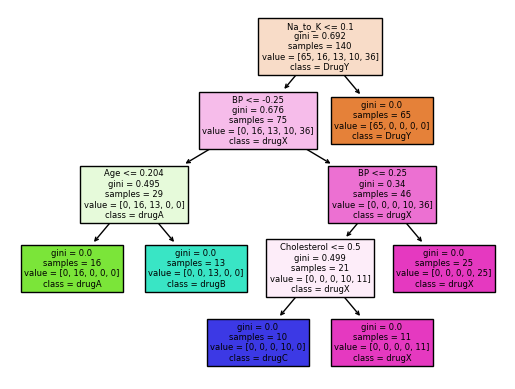

In [224]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

grid_params = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [3, 5, 7, 9, 11, 13, 15],
    'min_samples_split': [2, 3, 4, 5, 6, 7, 8], # minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7] # minimum number of samples required to be at a leaf node
}

tree = DecisionTreeClassifier(random_state = 42)
tree_tunned = GridSearchCV(
                estimator = tree,
                param_grid = grid_params,
                scoring = 'accuracy',
                cv = 5,
                verbose=0
            )

tree_tunned.fit(X_train, y_train)
y_pred = tree_tunned.predict(X_test)

print(tree_tunned.best_params_)
# plot_multi_class_roc_curve(y_test, y_pred)
plot_confusion_matrix(y_test, y_pred)
print(classification_report(y_test, y_pred, digits = 5, target_names = mapping.values(), zero_division=0))
plot_tree(tree_tunned.best_estimator_, feature_names=df.columns[:-1], class_names=list(mapping.values()), filled=True)

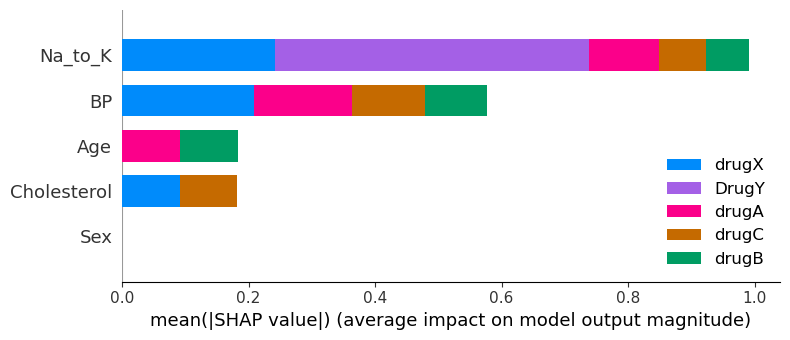

In [234]:
explainer = shap.TreeExplainer(tree_tunned.best_estimator_)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test, feature_names=df.columns[:-1], class_names=list(mapping.values()))

## Random Forest

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

forest = RandomForestClassifier(n_estimators = 30, criterion = 'entropy', random_state = 42)

forest.fit(X_train, y_train)
y_pred = forest.predict(X_test)

print(classification_report(y_test, y_pred, digits = 5, target_names = mapping.values(), zero_division=0))

              precision    recall  f1-score   support

       DrugY    1.00000   1.00000   1.00000        26
       drugA    1.00000   1.00000   1.00000         7
       drugB    1.00000   1.00000   1.00000         3
       drugC    1.00000   1.00000   1.00000         6
       drugX    1.00000   1.00000   1.00000        18

    accuracy                        1.00000        60
   macro avg    1.00000   1.00000   1.00000        60
weighted avg    1.00000   1.00000   1.00000        60



sh: 1: dot: not found


In [80]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

forest = RandomForestClassifier(n_estimators = 100, criterion = 'entropy', random_state = 42)
y_pred = cross_val_predict(forest, X, y, cv=10)

print(classification_report(y, y_pred, digits = 5, target_names = mapping.values(), zero_division=0))

              precision    recall  f1-score   support

       DrugY    0.98913   1.00000   0.99454        91
       drugA    0.95833   1.00000   0.97872        23
       drugB    1.00000   0.93750   0.96774        16
       drugC    1.00000   1.00000   1.00000        16
       drugX    1.00000   0.98148   0.99065        54

    accuracy                        0.99000       200
   macro avg    0.98949   0.98380   0.98633       200
weighted avg    0.99026   0.99000   0.98996       200



{'n_estimators': 150}


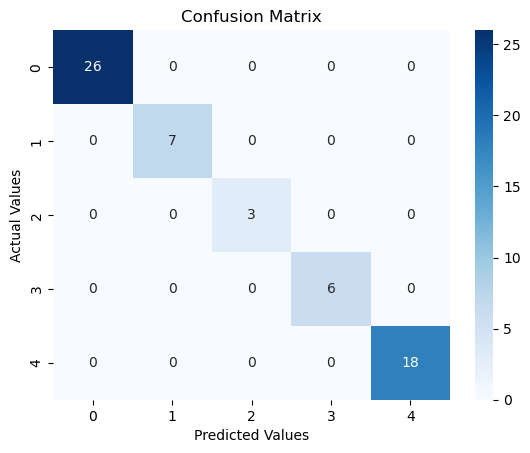

              precision    recall  f1-score   support

       DrugY    1.00000   1.00000   1.00000        26
       drugA    1.00000   1.00000   1.00000         7
       drugB    1.00000   1.00000   1.00000         3
       drugC    1.00000   1.00000   1.00000         6
       drugX    1.00000   1.00000   1.00000        18

    accuracy                        1.00000        60
   macro avg    1.00000   1.00000   1.00000        60
weighted avg    1.00000   1.00000   1.00000        60



In [141]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

grid_params = {
    'n_estimators': [10, 30, 50, 70, 100, 150, 200],
}

forest = RandomForestClassifier(random_state = 42)
forest_tunned = GridSearchCV(
                estimator = forest,
                param_grid = grid_params,
                scoring = 'accuracy',
                cv = 5,
                verbose=0
            )

forest_tunned.fit(X_train, y_train)
y_pred = forest_tunned.predict(X_test)

print(forest_tunned.best_params_)
plot_confusion_matrix(y_test, y_pred)
print(classification_report(y_test, y_pred, digits = 5, target_names = mapping.values(), zero_division=0))

## AdaBoostClassifier

In [82]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

ada = AdaBoostClassifier(n_estimators = 100, random_state = 42)

ada.fit(X_train, y_train)
y_pred = ada.predict(X_test)

print(classification_report(y_test, y_pred, digits = 5, target_names = mapping.values(), zero_division=0))

              precision    recall  f1-score   support

       DrugY    1.00000   1.00000   1.00000        26
       drugA    0.70000   1.00000   0.82353         7
       drugB    0.00000   0.00000   0.00000         3
       drugC    0.00000   0.00000   0.00000         6
       drugX    0.75000   1.00000   0.85714        18

    accuracy                        0.85000        60
   macro avg    0.49000   0.60000   0.53613        60
weighted avg    0.74000   0.85000   0.78655        60



In [83]:
ada = AdaBoostClassifier(n_estimators = 100, random_state = 42)
y_pred = cross_val_predict(ada, X, y, cv=5)

print(classification_report(y, y_pred, digits = 5, target_names = mapping.values(), zero_division=0))

              precision    recall  f1-score   support

       DrugY    0.98913   1.00000   0.99454        91
       drugA    0.58974   1.00000   0.74194        23
       drugB    0.00000   0.00000   0.00000        16
       drugC    0.00000   0.00000   0.00000        16
       drugX    0.76812   0.98148   0.86179        54

    accuracy                        0.83500       200
   macro avg    0.46940   0.59630   0.51965       200
weighted avg    0.72527   0.83500   0.77052       200



{'n_estimators': 10}


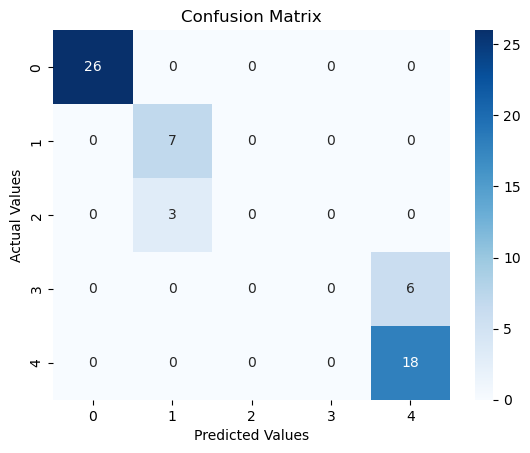

              precision    recall  f1-score   support

       DrugY    1.00000   1.00000   1.00000        26
       drugA    0.70000   1.00000   0.82353         7
       drugB    0.00000   0.00000   0.00000         3
       drugC    0.00000   0.00000   0.00000         6
       drugX    0.75000   1.00000   0.85714        18

    accuracy                        0.85000        60
   macro avg    0.49000   0.60000   0.53613        60
weighted avg    0.74000   0.85000   0.78655        60



In [143]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

grid_params = {
    'n_estimators': [10, 30, 50, 70, 100, 150, 200],
}

ada = AdaBoostClassifier(random_state = 42)
ada_tunned = GridSearchCV(
                estimator = ada,
                param_grid = grid_params,
                scoring = 'accuracy',
                cv = 10,
                verbose=0
            )

ada_tunned.fit(X_train, y_train)
y_pred = ada_tunned.predict(X_test)

print(ada_tunned.best_params_)
plot_confusion_matrix(y_test, y_pred)
print(classification_report(y_test, y_pred, digits = 5, target_names = mapping.values(), zero_division=0))

## Support Vector Machine (SVM)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)
svc = SVC()
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)

print(classification_report(y_test, y_pred, digits = 5, target_names = mapping.values(), zero_division=0))

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)
svc = SVC()
y_pred = cross_val_predict(svc, X, y, cv=5)

print(classification_report(y, y_pred, digits = 5, target_names = mapping.values(), zero_division=0))

Using train_test_split

In [85]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)
svc = SVC()
clf = GridSearchCV(svc, {'kernel':('linear', 'rbf', 'poly', 'sigmoid'), 'C':[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}, cv=10)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred, digits = 5, target_names = mapping.values(), zero_division=0))


              precision    recall  f1-score   support

       DrugY    1.00000   1.00000   1.00000        26
       drugA    1.00000   1.00000   1.00000         7
       drugB    1.00000   1.00000   1.00000         3
       drugC    1.00000   1.00000   1.00000         6
       drugX    1.00000   1.00000   1.00000        18

    accuracy                        1.00000        60
   macro avg    1.00000   1.00000   1.00000        60
weighted avg    1.00000   1.00000   1.00000        60



Using cross_val_predict

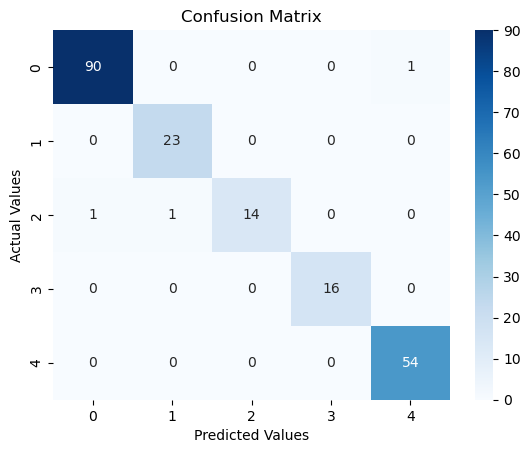

              precision    recall  f1-score   support

       DrugY    0.98901   0.98901   0.98901        91
       drugA    0.95833   1.00000   0.97872        23
       drugB    1.00000   0.87500   0.93333        16
       drugC    1.00000   1.00000   1.00000        16
       drugX    0.98182   1.00000   0.99083        54

    accuracy                        0.98500       200
   macro avg    0.98583   0.97280   0.97838       200
weighted avg    0.98530   0.98500   0.98474       200



In [44]:
svc = SVC()
clf = GridSearchCV(svc, {'kernel':('linear', 'rbf', 'poly', 'sigmoid'), 'C':[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}, cv=10)
y_pred = cross_val_predict(clf, X, y, cv=10)

plot_confusion_matrix(y, y_pred)

print(classification_report(y, y_pred, digits = 5, target_names = mapping.values(), zero_division=0))

Best combinations of hyperparameters:

Found best combination of hyperparameters:
{'C': 3, 'kernel': 'linear'}
{'C': 2, 'kernel': 'rbf'}
{'C': 4, 'kernel': 'linear'}
{'C': 5, 'kernel': 'linear'}
{'C': 3, 'kernel': 'linear'}
{'C': 3, 'kernel': 'rbf'}
{'C': 6, 'kernel': 'linear'}
{'C': 4, 'kernel': 'linear'}
{'C': 2, 'kernel': 'rbf'}
{'C': 5, 'kernel': 'linear'}


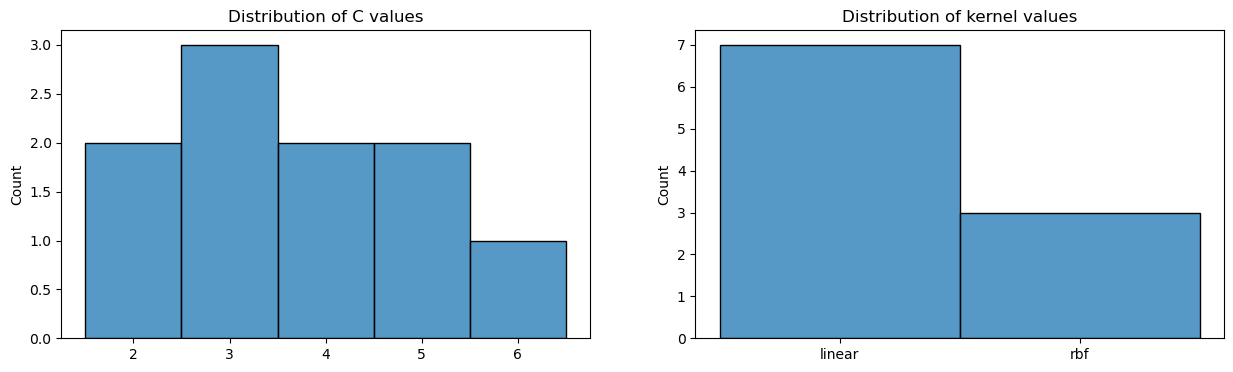

In [144]:
kf = KFold(n_splits=10, shuffle=True, random_state=42)
C_types = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
kernel_types = ['linear', 'rbf', 'poly', 'sigmoid']
gamma_types = ['scale', 'auto']
hyper_parameters = {}
counter = 0
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    svc = SVC()
    clf = GridSearchCV(svc, {'kernel':('linear', 'rbf', 'poly', 'sigmoid',  ), 'C':C_types}, cv=10)
    clf.fit(X_train, y_train)
    hyper_parameters[counter] = [clf.best_params_]
    counter += 1

found_parameters = hyper_parameters.values()

print("Found best combination of hyperparameters:")
for parameters in found_parameters:
    print(parameters[0])

# sub-plot distribution of C values and sub-plot distribution of kernel values
C_values = [parameters[0]['C'] for parameters in found_parameters]
kernel_values = [parameters[0]['kernel'] for parameters in found_parameters]

fig, axs = plt.subplots(1, 2, figsize=(15, 4))

plt.subplot(1, 2, 1)
sns.histplot(data = C_values, palette = "cool", discrete=True, stat="count", binwidth=1)
plt.title("Distribution of C values")

plt.subplot(1, 2, 2)
sns.histplot(data = kernel_values, palette = "cool", discrete=True, stat="count")

plt.title("Distribution of kernel values")
plt.show()

## K-Nearest Neighbors (KNN)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

print(classification_report(y_test, y_pred, digits = 5, target_names = mapping.values(), zero_division=0))

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)
knn = KNeighborsClassifier()
y_pred = cross_val_predict(knn, X, y, cv=5)

print(classification_report(y, y_pred, digits = 5, target_names = mapping.values(), zero_division=0))

In [88]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)
knn = KNeighborsClassifier()
clf = GridSearchCV(knn, {'n_neighbors':[1, 2, 3, 4, 5, 6, 7, 8, 9, 10], 'weights': ["uniform", "distance"], 'algorithm': ["auto", "ball_tree", "kd_tree", "brute"], 'metric': ["minkowski", "l1", "l2"]}, cv=10)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred, digits = 5, target_names = mapping.values(), zero_division=0))

              precision    recall  f1-score   support

       DrugY    1.00000   0.92308   0.96000        26
       drugA    1.00000   1.00000   1.00000         7
       drugB    0.60000   1.00000   0.75000         3
       drugC    1.00000   0.50000   0.66667         6
       drugX    0.85714   1.00000   0.92308        18

    accuracy                        0.91667        60
   macro avg    0.89143   0.88462   0.85995        60
weighted avg    0.93714   0.91667   0.91376        60



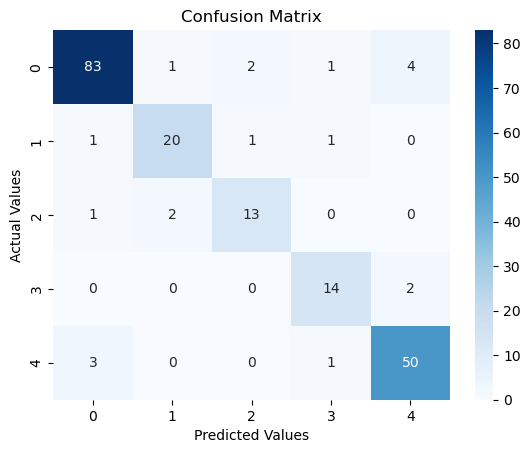

              precision    recall  f1-score   support

       DrugY    0.94318   0.91209   0.92737        91
       drugA    0.86957   0.86957   0.86957        23
       drugB    0.81250   0.81250   0.81250        16
       drugC    0.82353   0.87500   0.84848        16
       drugX    0.89286   0.92593   0.90909        54

    accuracy                        0.90000       200
   macro avg    0.86833   0.87902   0.87340       200
weighted avg    0.90110   0.90000   0.90029       200



In [45]:
knn = KNeighborsClassifier()
clf = GridSearchCV(knn, {'n_neighbors':[1, 2, 3, 4, 5, 6, 7, 8, 9, 10], 'weights': ["uniform", "distance"], 'algorithm': ["auto", "ball_tree", "kd_tree", "brute"], 'metric': ["minkowski", "l1", "l2"]}, cv=10)
y_pred = cross_val_predict(clf, X, y, cv=10)

plot_confusion_matrix(y, y_pred)

print(classification_report(y, y_pred, digits = 5, target_names = mapping.values(), zero_division=0))

Found best combination of hyperparameters:
{'algorithm': 'auto', 'metric': 'l1', 'n_neighbors': 1, 'weights': 'uniform'}
{'algorithm': 'auto', 'metric': 'l1', 'n_neighbors': 9, 'weights': 'distance'}
{'algorithm': 'auto', 'metric': 'l1', 'n_neighbors': 9, 'weights': 'distance'}
{'algorithm': 'auto', 'metric': 'minkowski', 'n_neighbors': 5, 'weights': 'distance'}
{'algorithm': 'auto', 'metric': 'l1', 'n_neighbors': 3, 'weights': 'distance'}


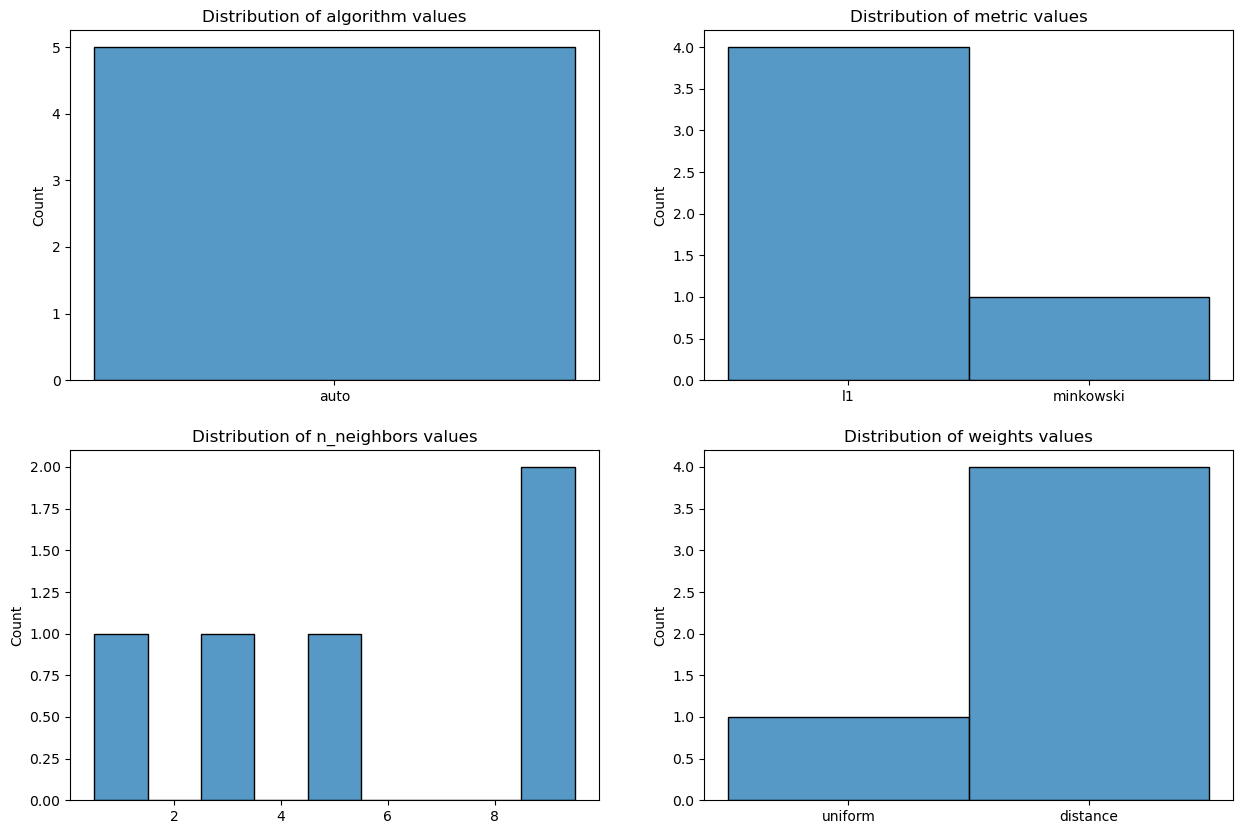

In [90]:
kf = KFold(n_splits=10, shuffle=True, random_state=42)

hyper_parameters = {}
counter = 0
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    knn = KNeighborsClassifier()
    clf = GridSearchCV(knn, {'n_neighbors':[1, 2, 3, 4, 5, 6, 7, 8, 9, 10], 'weights': ["uniform", "distance"], 'algorithm': ["auto", "ball_tree", "kd_tree", "brute"], 'metric': ["minkowski", "l1", "l2"]}, cv=10)
    clf.fit(X_train, y_train)
    hyper_parameters[counter] = [clf.best_params_]
    counter += 1

found_parameters = hyper_parameters.values()

print("Found best combination of hyperparameters:")
for parameters in found_parameters:
    print(parameters[0])


# sub-plot distribution of algorithm, sub-plot distribution of metric, sub-plot distribution of n_neighbors, sub-plot distribution of weights
algorithm_values = [parameters[0]['algorithm'] for parameters in found_parameters]
metric_values = [parameters[0]['metric'] for parameters in found_parameters]
n_neighbors_values = [parameters[0]['n_neighbors'] for parameters in found_parameters]
weights_values = [parameters[0]['weights'] for parameters in found_parameters]

fig, axs = plt.subplots(2, 2, figsize=(15, 10))

plt.subplot(2, 2, 1)
sns.histplot(data = algorithm_values, palette = "cool", discrete=True, stat="count")
plt.title("Distribution of algorithm values")

plt.subplot(2, 2, 2)
sns.histplot(data = metric_values, palette = "cool", discrete=True, stat="count")
plt.title("Distribution of metric values")

plt.subplot(2, 2, 3)
sns.histplot(data = n_neighbors_values, palette = "cool", discrete=True, stat="count")
plt.title("Distribution of n_neighbors values")

plt.subplot(2, 2, 4)
sns.histplot(data = weights_values, palette = "cool", discrete=True, stat="count")
plt.title("Distribution of weights values")

plt.show()



## Artificial Neural Network (ANN)

In [91]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

nn = MLPClassifier(hidden_layer_sizes=(10, 10, 10), max_iter=2000)

nn.fit(X_train, y_train)
y_pred = nn.predict(X_test)

print(classification_report(y_test, y_pred, digits = 5, target_names = mapping.values(), zero_division=0))

              precision    recall  f1-score   support

       DrugY    1.00000   0.95000   0.97436        20
       drugA    1.00000   1.00000   1.00000         6
       drugB    0.75000   1.00000   0.85714         3
       drugC    1.00000   1.00000   1.00000         6
       drugX    1.00000   1.00000   1.00000        15

    accuracy                        0.98000        50
   macro avg    0.95000   0.99000   0.96630        50
weighted avg    0.98500   0.98000   0.98117        50



In [92]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

nn = MLPClassifier(hidden_layer_sizes=(10, 10, 10), max_iter=2000)
y_pred = cross_val_predict(nn, X, y, cv=10)

print(classification_report(y, y_pred, digits = 5, target_names = mapping.values(), zero_division=0))

              precision    recall  f1-score   support

       DrugY    0.98876   0.96703   0.97778        91
       drugA    0.91667   0.95652   0.93617        23
       drugB    0.88235   0.93750   0.90909        16
       drugC    0.87500   0.87500   0.87500        16
       drugX    0.96296   0.96296   0.96296        54

    accuracy                        0.95500       200
   macro avg    0.92515   0.93980   0.93220       200
weighted avg    0.95589   0.95500   0.95528       200



{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (10, 10, 10), 'learning_rate': 'constant'}


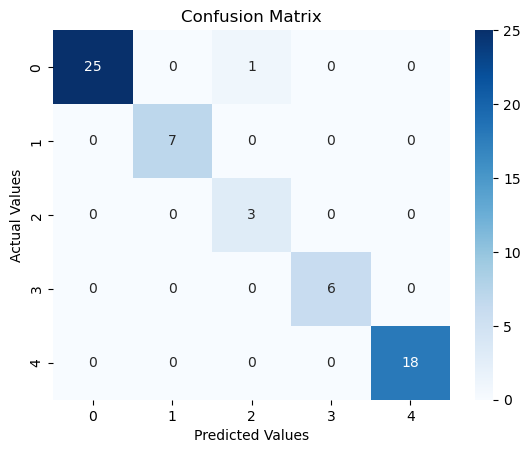

              precision    recall  f1-score   support

       DrugY    1.00000   0.96154   0.98039        26
       drugA    1.00000   1.00000   1.00000         7
       drugB    0.75000   1.00000   0.85714         3
       drugC    1.00000   1.00000   1.00000         6
       drugX    1.00000   1.00000   1.00000        18

    accuracy                        0.98333        60
   macro avg    0.95000   0.99231   0.96751        60
weighted avg    0.98750   0.98333   0.98436        60



In [145]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

grid_params = {
    'hidden_layer_sizes': [(10, 10, 10), (20, 20, 20), (30, 30, 30)],
    'activation': ['tanh', 'relu'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive']
}

nn_tunned = GridSearchCV(
            estimator=MLPClassifier(max_iter=2000),
            param_grid=grid_params,
            scoring='accuracy',
            cv=5
        )

nn_tunned.fit(X_train, y_train)
y_pred = nn_tunned.predict(X_test)

print(nn_tunned.best_params_)
plot_confusion_matrix(y_test, y_pred)
print(classification_report(y_test, y_pred, digits = 5, target_names = mapping.values(), zero_division=0))